# MHKiT Environmental Contours

Environmental contours describing extreme sea states can be used for numerical or physical model simulations analyzing the design-response of WECs. MHKiT includes functions adapted from the [WDRT](https://github.com/WEC-Sim/WDRT) for creating environmental contours of extreme sea states using a principle components analysis (PCA) methodology with additional improvements for characterizing the joint probability distribution of sea state variables of interest. These environmental contours, characterized by combinations of significant wave height (Hs) and either energy period (Te) or peak period (Tp), provide inputs that are associated with a certain reliability interval. These reliability levels are needed to drive both contour and full sea state style long-term extreme response analyses. This notebook will swalk through the following steps to find a 100 year contour for NDBC buoy 46022.

 1. Request Spectral Wave Density Data from NDBC
 2. Calculate Hs and Te using the NDBC Data
 3. Perform the Principal Component Analysis
 4. Find the contour line for the 100 year 
 5. Plot the results

Start by importing the necessary python packages and MHKiT module.

In [1]:
from mhkit.wave import resource
import matplotlib.pyplot as plt
from mhkit.wave.io import ndbc
from scipy import stats
import pandas as pd
import numpy as np


## 1. Request Spectral Wave Density Data from NDBC
   
MHKiT can request historical data from the National Data Buoy Center (NDBC). This can be done by requesting the available data for a given parameter and buoy number then requesting the data for the desired data. We will start by looking at the function documentation for `mhkit.wave.io.ndbc.available_data`.

In [2]:
help(ndbc.available_data)

Help on function available_data in module mhkit.wave.io.ndbc:

available_data(parameter, buoy_number=None, proxy=None)
    For a given parameter this will return a DataFrame of years, 
    station IDs and file names that contain that parameter data.              
    
    Parameters
    ----------
    parameter: string
        'swden' :       'Raw Spectral Wave Current Year Historical Data'
        'stdmet':   'Standard Meteorological Current Year Historical Data'
        
    buoy_number: string (optional)
        Buoy Number.  5-character alpha-numeric station identifier   
        
    proxy: dict
            Proxy dict passed to python requests, 
        (e.g. proxy_dict= {"http": 'http:wwwproxy.yourProxy:80/'})  
        
    Returns
    -------
    available_data: DataFrame
        DataFrame with station ID, years, and NDBC file names.



Looking at the help for the `ndbc.available_data` we can see that the function requires a parameter to be specified and that we can optionally provide a buoy_number as a string. Of the listed parameters we are interesed in `'swden'` and we will specify the buoy number as `'46022'`.

In [3]:
# Specify the parameter to be spectral wave density and the buoy number to be 46022
spectral_wave_density='swden'
buoy_number = '46022' 
available_data= ndbc.available_data(spectral_wave_density, buoy_number)
# Remove 'b' from 'b2004' and convert strings to numeric type
available_data['year']=pd.to_numeric(available_data.year.str.strip('b'))

The `ndbc.available_data` function has returned a dataframe with columns 'id', 'year', and 'filename'. All three of these columns are of type string because buoy_numbers (id) are defined as 5 digit alpha number specifiers, years sometimes split (e.g. 'b2004').  In this case the years span from 1996 to 2019 and for demonstration we have decided we are interested in the data between years 1996 and 2012. Because the list needs to contain `'b2004'` 

In [4]:
# Create a list of years of interest
subYears = [*range(1996,2013)]
# Slice the DataFrame on years of interest
yearsOfInterest = available_data[available_data.year.isin(subYears)]

Using the filenames from our `yearsOfInterest` we can request data from NDC and return a dictionary of DataFrames indexed by years.

In [5]:
# Get dictionary of parameter data by year
filenames= yearsOfInterest['filename']
ndbc_data = ndbc.request_data(spectral_wave_density, filenames)

# Lastly we will convert a DateTime Index 
mhkit_data={}
# Create a Datetime Index and remove NOAA date columns for each year
for year in ndbc_data:
   year_data = ndbc_data[year]
   year_data['date'], ndbc_date_cols = ndbc.dates_to_datetime(spectral_wave_density, 
                                                              year_data, 
                                                              return_date_cols=True)
   year_data = year_data.drop(ndbc_date_cols, axis=1)
   year_data = year_data.set_index('date')
   # Convert columns to float now that the ndbc_date_cols (type=str) are gone
   year_data.columns = year_data.columns.astype(float)     
   mhkit_data[year] = year_data

## 2. Calculate Hs and Te using the NDBC Data



In [6]:
#=======================================================================
# Calculate Hm0 and Te for each year
#=======================================================================
Hs={}
Te={}
for year in mhkit_data:
    year_data = mhkit_data[year]
    Hs[year] = resource.significant_wave_height(year_data.T)
    Te[year] = resource.energy_period(year_data.T)


Hs_list = [ v for k,v in Hs.items()]; 
Te_list = [ v for k,v in Te.items()]; 

Hs= pd.concat(Hs_list ,axis=0)
Te= pd.concat(Te_list ,axis=0)

Hs['Te'] = Te.Te
Hs.dropna(inplace=True)

# Save the data locally
Hs.to_pickle(f'{buoy_number}Hm0Te.pkl')

## 3. Perform the Principal Component Analysis 


In [7]:
df_raw=Hs.copy(deep=True)

# Remove Outliers
df = df_raw[df_raw['Hm0'] < 20]

PCA  = resource.principal_component_analysis(df.Hm0.values, df.Te.values)

## 4. Find the contour line for the 100 year

In [8]:
# Declare required parameters
time_SS = 1.  # Sea state duration (hrs)
time_R = 100  # Return periods (yrs) of interest
Hs_Return, T_Return = resource.environmental_contour(time_SS, time_R, PCA , nb_steps=1000)

## 5. Plot overlay of the data and Contour
Finally, annual energy produced is computed, as shown below.

Note: The function `energy_produced` returns units of Joules(3600 Joules = 1 Wh).

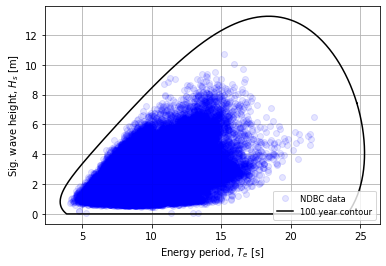

In [9]:
# """
# Display a plot of the 100-year return contour, full sea state samples
# and contour samples
# """

plt.figure()

plt.plot(df.Te, df.Hm0, 'bo', alpha=0.1, label='NDBC data')
plt.plot(T_Return, Hs_Return, 'k-', label='100 year contour')

plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.xlabel('Energy period, $T_e$ [s]')
plt.ylabel('Sig. wave height, $H_s$ [m]')
plt.show()